## Homework 6

Adam Grabowski |
CS 541 Deep Learning |
November 6, 2023

## Problem 1

In [30]:
import numpy as np

In [32]:
def scaled_dot_product_attention(query, key, value):
    # Compute dot product between query and transposed key
    dot_product = np.matmul(query, key.transpose(0, 2, 1))

    # Scale dot product by square root of key's dimension
    scaled_dot_product = dot_product / np.sqrt(key.shape[-1])

    # Apply softmax to obtain attention scores
    attention_scores = np.exp(scaled_dot_product - np.max(scaled_dot_product, axis=-1, keepdims=True))
    attention_scores /= np.sum(attention_scores, axis=-1, keepdims=True)

    # Weight values by attention scores to get output
    output = np.matmul(attention_scores, value)

    return output

In [33]:
# Define dimensions of input data
batch_size = 2
input_seq_length = 3
query_dim = 4
key_dim = 4
value_dim = 5

# Generate random input data for query, key, and value
query = np.random.rand(batch_size, input_seq_length, query_dim)
key = np.random.rand(batch_size, input_seq_length, key_dim)
value = np.random.rand(batch_size, input_seq_length, value_dim)

# Apply scaled dot-product attention mechanism
output = scaled_dot_product_attention(query, key, value)

# Print shape of output
print("Output shape:", output.shape)

Output shape: (2, 3, 5)


In [34]:
def split_heads(x, num_heads):
    # Get dimensions of input tensor
    batch_size, input_seq_length, concatenated_dim = x.shape

    # Calculate dimension of each head
    head_dim = concatenated_dim // num_heads

    # Reshape input tensor to split last dimension into multiple heads
    x = x.reshape(batch_size, input_seq_length, num_heads, head_dim)

    return x

In [35]:
# Define dimensions for input data
batch_size = 2
input_seq_length = 3
num_heads = 2
concatenated_dim = 8

# Generate random input data with specified dimensions
x = np.random.rand(batch_size, input_seq_length, num_heads * concatenated_dim)

# Apply split_heads function to split last dimension into multiple heads
split_result = split_heads(x, num_heads)

# Print shape of resulting tensor after splitting
print("Split result shape:", split_result.shape)

Split result shape: (2, 3, 2, 8)


In [36]:
def multi_head_scaled_attention(query, key, value, num_heads, Wq, Wk, Wv):
    # Project input tensors using learnable weight matrices
    projected_query = np.matmul(query, Wq)
    projected_key = np.matmul(key, Wk)
    projected_value = np.matmul(value, Wv)

    # Split each projected tensor into multiple heads
    projected_query = split_heads(projected_query, num_heads)
    projected_key = split_heads(projected_key, num_heads)
    projected_value = split_heads(projected_value, num_heads)

    # List to store outputs from each head
    head_outputs = []

    # Apply scaled dot-product attention for each head
    for i in range(num_heads):
        head_output = scaled_dot_product_attention(projected_query[:, :, i, :], projected_key[:, :, i, :], projected_value[:, :, i, :])
        head_outputs.append(head_output)

    # Concatenate outputs from all heads along last dimension
    multi_head_output = np.concatenate(head_outputs, axis=-1)

    return multi_head_output

In [37]:
# Define dimensions for input data
batch_size = 2
input_seq_length = 3
query_dim = 4
key_dim = 4
value_dim = 5
num_heads = 2

# Generate random input data for query, key, and value
query = np.random.rand(batch_size, input_seq_length, query_dim)
key = np.random.rand(batch_size, input_seq_length, key_dim)
value = np.random.rand(batch_size, input_seq_length, value_dim)

# Generate random learnable weight matrices for projection
Wq = np.random.rand(query_dim, num_heads * query_dim)
Wk = np.random.rand(key_dim, num_heads * key_dim)
Wv = np.random.rand(value_dim, num_heads * value_dim)

# Apply multi-head scaled attention mechanism
output = multi_head_scaled_attention(query, key, value, num_heads, Wq, Wk, Wv)

# Print shape of resulting multi-head attention output
print("Output shape:", output.shape)

Output shape: (2, 3, 10)


### Problem 2

In [38]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torchtext.vocab as vocab
from sklearn.model_selection import train_test_split

import time
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# Define special tokens for start and end of scentence
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        # Language class to manage vocabulary
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2

    def addSentence(self, sentence):
        # Add each word in sentence to language vocabulary
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Add word to vocabulary not already present, update counts otherwise
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [43]:
def unicodeToAscii(s):
    # Convert Unicode to ASCII characters
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    # Convert to ASCII, lowercase, and strip
    s = unicodeToAscii(s.lower().strip())

    # Add space before punctuation and remove non-alphabetic characters
    s = re.sub(r'([.!?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z!?]+', r' ', s)
    return s.strip()

In [45]:
def readLangs(lang1, lang2, reverse=False):
    # Read lines from specified file and split into pairs
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Normalize each pair of sentences
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # If reverse True, swap order of language pairs
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [46]:
# Maximum allowed length for sentence pairs
MAX_LENGTH = 10

# French sentence prefixes to filter pairs
fr_prefixes = (
    "je suis ", "j'suis ",
    "il est ", "il'st ",
    "elle est ", "elle'st ",
    "tu es ", "t'es ",
    "nous sommes ", "nous'sommes ",
    "ils sont ", "ils'sont "
)

def filterPair(p):
    # Filter single sentence pair based on length and prefixes
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(fr_prefixes)

def filterPairs(pairs):
    # Filter list of sentence pairs using filterPair
    return [pair for pair in pairs if filterPair(pair)]

In [47]:
def prepareData(lang1, lang2, reverse=False):
    # Create language objects and get pairs from file
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)

    # Filter pairs based on length and prefixes
    pairs = filterPairs(pairs)

    # Add sentences from filtered pairs to language objects
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    return input_lang, output_lang, pairs

# Prepare data for English to French translation
input_lang, output_lang, pairs = prepareData('eng', 'fra')

In [48]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Define GRU layer and apply dropout to input
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # Apply dropout to embedded input and pass it through GRU layer
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [49]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)

        # Define GRU layer and linear layer
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        # Loop over maximum sequence length
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            # Determine next decoder input
            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        # Concatenate decoder outputs and apply log-softmax
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        # Apply embedding, ReLU, GRU, and linear layers
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [50]:
def indexesFromSentence(lang, sentence):
    # Convert sentence to indexes using language vocabulary
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    # Create tensor from sentence
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    # Create input and target tensors from sentence pair
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    # Prepare language data and pairs
    input_lang, output_lang, pairs = prepareData('eng', 'fra')

    # Initialize arrays for input and target sentence indices
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    # Convert sentences to indices and update arrays
    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Split data into training and testing sets
    input_ids_train, input_ids_test, target_ids_train, target_ids_test = train_test_split(
        input_ids, target_ids, test_size=0.2, random_state=42
    )

    # Create PyTorch datasets and data loaders
    train_data = TensorDataset(torch.LongTensor(input_ids_train).to(device),
                               torch.LongTensor(target_ids_train).to(device))
    test_data = TensorDataset(torch.LongTensor(input_ids_test).to(device),
                              torch.LongTensor(target_ids_test).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    # Return language objects and data loaders
    return input_lang, output_lang, train_dataloader, test_dataloader

In [51]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    # Initialize total loss for epoch
    total_loss = 0

    # Iterate over batches in dataloader
    for data in dataloader:
        # Extract input and target tensors from batch
        input_tensor, target_tensor = data

        # Zero gradients of both encoder and decoder
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Forward pass through encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Forward pass through decoder
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Calculate loss and perform backpropagation
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        total_loss += loss.item()

        # Update encoder and decoder parameters
        encoder_optimizer.step()
        decoder_optimizer.step()

    # Return average loss for the epoch
    return total_loss / len(dataloader)

In [53]:
def evaluate(dataloader, encoder, decoder, criterion):
    with torch.no_grad():
        # Initialize total loss for evaluation
        total_loss = 0

        # Iterate over batches in dataloader
        for data in dataloader:
            # Extract input and target tensors from batch
            input_tensor, target_tensor = data

            # Forward pass through encoder
            encoder_outputs, encoder_hidden = encoder(input_tensor)

            # Forward pass through decoder
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            # Calculate loss and accumulate for evaluation
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            total_loss += loss.item()

    # Return average loss for evaluation
    return total_loss / len(dataloader)

In [55]:
def translate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        # Convert input sentence to PyTorch tensor
        input_tensor = tensorFromSentence(input_lang, sentence)

        # Forward pass through encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Forward pass through decoder
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

        # Extract index with highest probability for each position
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        # Convert indices to words in output language
        decoded_words = []
        for idx in decoded_ids:
            # Stop decoding when encounter EOS token
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words

In [56]:
def train(train_dataloader, test_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=5):
    # Lists to store training and test losses for each epoch
    train_losses = []
    test_losses = []

    # Initialize Adam optimizers for encoder and decoder
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Define negative log likelihood loss criterion
    criterion = nn.NLLLoss()

    # Iterate over epochs
    for epoch in range(1, n_epochs + 1):
        # Train model for one epoch and record training loss
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_losses.append(train_loss)

        # Evaluate model on test set and record test loss
        test_loss = evaluate(test_dataloader, encoder, decoder, criterion)
        test_losses.append(test_loss)

        # Print training and test losses for each epoch
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # Print translation example every 5 epochs
        if epoch % print_every == 0:
            input_sentence = pairs[0][0]
            output_words = translate(encoder, decoder, input_sentence, input_lang, output_lang)
            output_sentence = ' '.join(output_words)
            print(f'Translation: {input_sentence} -> {output_sentence}')

    return train_losses, test_losses

In [59]:
# Define dimensions and batch size
input_size = 100
hidden_size = 100
batch_size = 32

# Obtain language data and data loaders for training and testing
input_lang, output_lang, train_dataloader, test_dataloader = get_dataloader(batch_size)

# Initialize Encoder and Decoder models
encoder = EncoderRNN(input_size, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# Load pre-trained GloVe word embeddings
glove = vocab.GloVe(name='6B', dim=100)

# Modify GloVe's vocabulary to include unknown token
glove.itos = ['<unk>'] + glove.itos
glove.stoi = {word: index for index, word in enumerate(glove.itos)}

# Add zero vector for unknown token
zero_vector = np.zeros((1, glove.vectors.shape[1]), dtype=np.float32)
glove.vectors = torch.cat([torch.tensor(zero_vector), glove.vectors])

# Create embedding layer from pre-trained vectors
embedding = nn.Embedding.from_pretrained(glove.vectors).to(device)

# Freeze embedding layer to keep pre-trained weights fixed
embedding.weight.requires_grad = False
encoder.embedding = embedding

# Train sequence-to-sequence model for 80 epochs
train_losses, test_losses = train(train_dataloader, test_dataloader, encoder, decoder, 80)

Epoch 1, Train Loss: 3.7513, Test Loss: 2.7930
Epoch 2, Train Loss: 2.5720, Test Loss: 2.4746
Epoch 3, Train Loss: 2.2656, Test Loss: 2.2725
Epoch 4, Train Loss: 2.0484, Test Loss: 2.1408
Epoch 5, Train Loss: 1.8944, Test Loss: 2.0559
Translation: i fell -> je suis desole de vous avoir fait <EOS>
Epoch 6, Train Loss: 1.7698, Test Loss: 1.9989
Epoch 7, Train Loss: 1.6646, Test Loss: 1.9550
Epoch 8, Train Loss: 1.5739, Test Loss: 1.9122
Epoch 9, Train Loss: 1.4923, Test Loss: 1.8825
Epoch 10, Train Loss: 1.4207, Test Loss: 1.8564
Translation: i fell -> je suis alle a la plage <EOS>
Epoch 11, Train Loss: 1.3548, Test Loss: 1.8378
Epoch 12, Train Loss: 1.2956, Test Loss: 1.8242
Epoch 13, Train Loss: 1.2415, Test Loss: 1.8103
Epoch 14, Train Loss: 1.1942, Test Loss: 1.8064
Epoch 15, Train Loss: 1.1463, Test Loss: 1.7963
Translation: i fell -> je suis alle a la gare a la maison <EOS>
Epoch 16, Train Loss: 1.1031, Test Loss: 1.7896
Epoch 17, Train Loss: 1.0628, Test Loss: 1.7865
Epoch 18, Tra

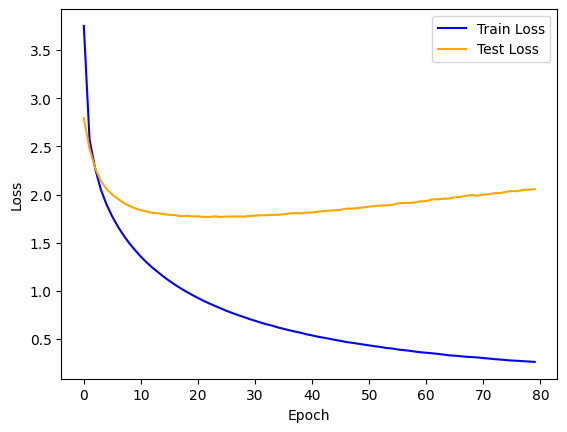

In [60]:
# Plot train and test losses over epochs
plt.figure()
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()